In [27]:
using LinearAlgebra
using CairoMakie
using SparseArrays
using Peaks
using Statistics

include("../src/kpm.jl")
include("../src/models.jl")
include("../src/meanfield.jl")
include("../src/run_scf.jl")

run_scf_loop (generic function with 1 method)

# Defining the Hamiltonian

In [276]:
HamiltonianData = (N_sites = 256, t = 1.0,Δ = 0.5, periodic=false, E_Fermi = 0.0)
HamiltonianData = one_dimensional_chain_gapped(HamiltonianData)

(N_sites = 256, t = 1.0, Δ = 0.5, periodic = false, E_Fermi = 0.0, H = sparse([1, 2, 1, 2, 3, 2, 3, 4, 3, 4  …  253, 254, 253, 254, 255, 254, 255, 256, 255, 256], [1, 1, 2, 2, 2, 3, 3, 3, 4, 4  …  253, 253, 254, 254, 254, 255, 255, 255, 256, 256], [0.25, -1.0, -1.0, -0.25, -1.0, -1.0, 0.25, -1.0, -1.0, -0.25  …  0.25, -1.0, -1.0, -0.25, -1.0, -1.0, 0.25, -1.0, -1.0, -0.25], 256, 256))

# Obtaining eigenvalues and eigenvectors and computing the exact density matrix at $E_F = 0$

In [277]:
E, V = eigen(Matrix(HamiltonianData.H))

P = V * Diagonal(map(x -> x < HamiltonianData.E_Fermi ? 1.0 : 0.0, E)) * V';

# Comparing Diagonal and 1st Off-Diagonal

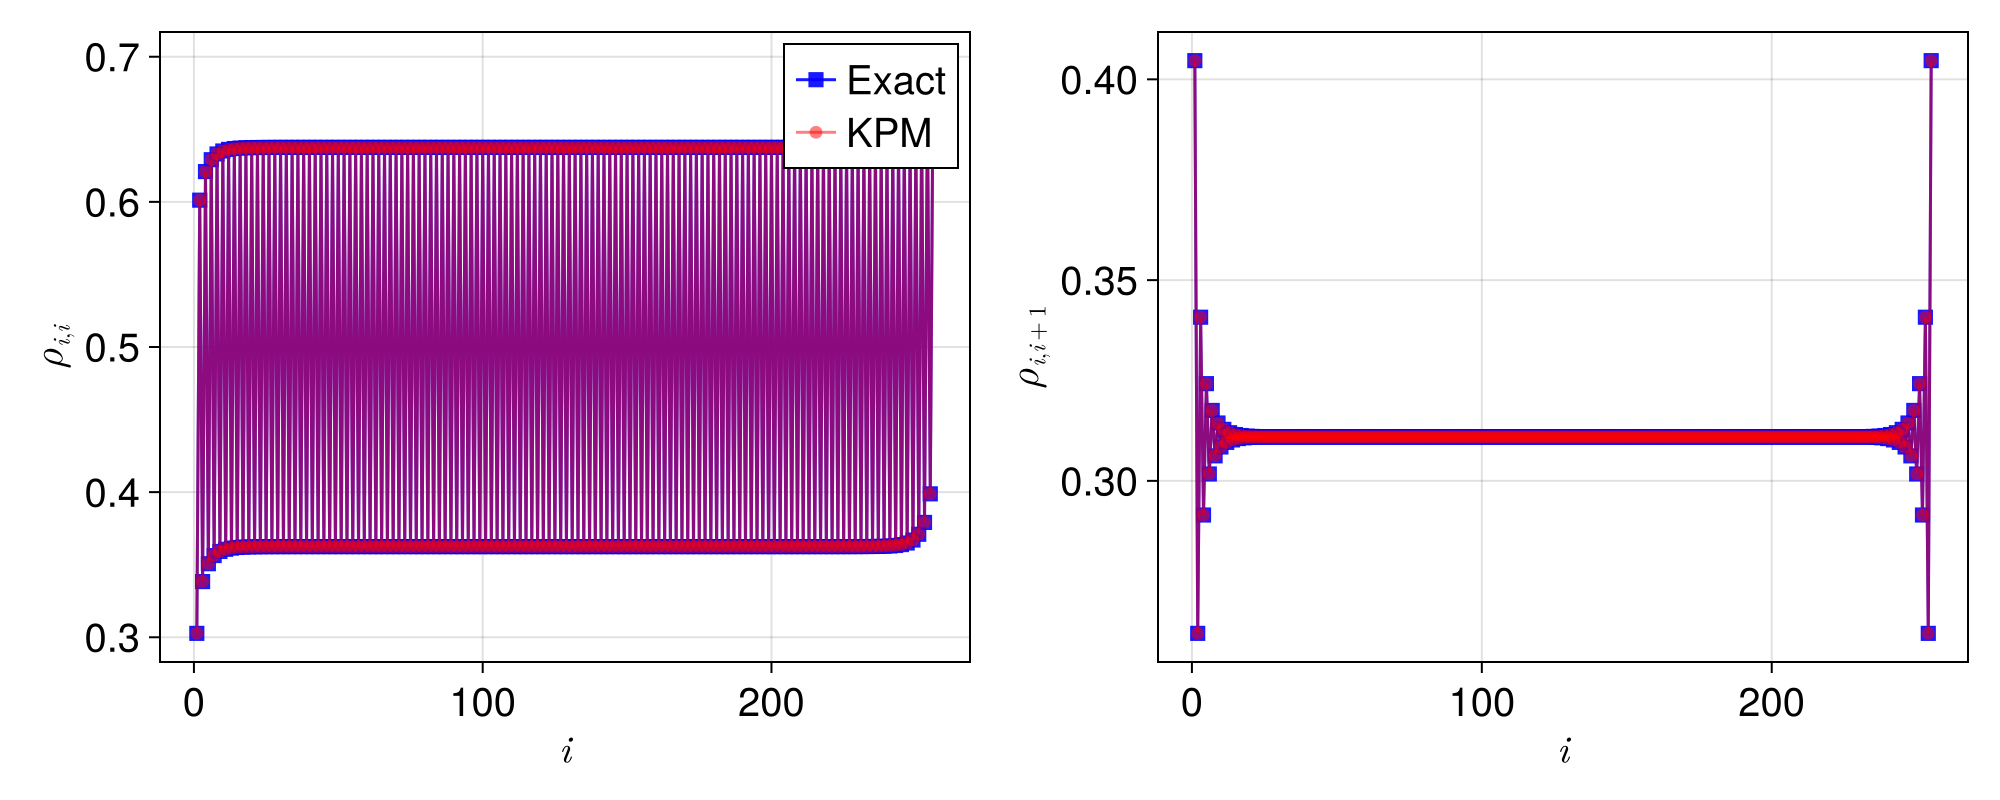

CairoMakie.Screen{IMAGE}


In [286]:
rescaling_kpm = (a = 2.5, b = 0.0)


kpm_run_Params  = (
     N_max = 256,
     compute_density_matrix = true,
     compute_local_density_of_states = true,
     Energies = Float64[-0.1,0.0,0.1])
N_max = 256
kpm_result = run_kpm_evolution(HamiltonianData, rescaling_kpm, kpm_run_Params)
diagonal_exact = diag(P)
diagonal_kpm = diag(kpm_result.density_matrix)

offdiagonal_exact = diag(P, 1)
offdiagonal_kpm = diag(kpm_result.density_matrix, 1)

fig = Figure(size = (1000, 400),fontsize=20)
ax1 = Axis(fig[1, 1], xlabel=L"i",ylabel=L"\rho_{i,i}")
scatterlines!(ax1, 1:length(diagonal_exact), diagonal_exact, marker=:rect, color=(:blue,0.9),label = "Exact",markersize=12)
scatterlines!(ax1, 1:length(diagonal_kpm), diagonal_kpm, marker=:circle, color=(:red,0.5),label = "KPM")

axislegend(ax1)

ax1 = Axis(fig[1, 2], xlabel=L"i",ylabel=L"\rho_{i,i+1}")
scatterlines!(ax1, 1:length(diagonal_exact)-1, offdiagonal_exact, marker=:rect, color=(:blue,0.9),label = "Exact",markersize=12)
scatterlines!(ax1, 1:length(diagonal_kpm)-1, offdiagonal_kpm, marker=:circle, color=(:red,0.5),label = "KPM")


display(fig)

# save("../../Figures/Diagonal_N=$(HamiltonianData.N_sites)_Nmax=$(N_max)-Δ=$(HamiltonianData.Δ).pdf", fig)

In [290]:
kpm_result.spectral_function[:,:,3]

256×256 Matrix{Float64}:
  0.00157764   -7.23098e-5   -0.00152174   …   2.78527e-31  -5.04518e-32
 -7.23098e-5    1.97505e-5    6.52227e-5       7.55792e-30   2.53301e-31
 -0.00152174    6.52227e-5    0.00147805      -4.00051e-29   7.60837e-30
  0.000137533  -3.08273e-5   -0.000126538     -5.50784e-28  -3.64542e-29
  0.00142214   -5.42285e-5   -0.00139044       2.80014e-27  -5.58392e-28
 -0.000191761   3.54143e-5    0.000179358  …   2.60177e-26   2.5574e-27
 -0.00129085    4.18251e-5    0.00126946      -1.27254e-25   2.6576e-26
  0.000233586  -3.58839e-5   -0.000221313     -8.95571e-25  -1.16523e-25
  0.00113817   -2.95516e-5   -0.0011254        4.22071e-24  -9.22147e-25
 -0.000263138   3.38762e-5    0.000251879      2.39417e-23   3.87616e-24
 -0.000972725   1.82931e-5    0.000966922  …  -1.08886e-22   2.48639e-23
  0.000281431  -3.05319e-5   -0.000271629     -5.17343e-22  -1.00331e-22
  0.000801477  -8.49153e-6   -0.000801174      2.27381e-21  -5.42207e-22
  ⋮                         

# error as function of Chebyshev moments

In [61]:
# Defining the Hamiltonian
HamiltonianData = (N_sites = 512, t = 1.0,Δ = 0.5, periodic=false, E_Fermi = 0.0)
HamiltonianData = one_dimensional_chain_gapped(HamiltonianData)

# Obtaining eigenvalues and eigenvectors and computing the exact density matrix at $E_F = 0$
E, V = eigen(Matrix(HamiltonianData.H))
P = V * Diagonal(map(x -> x < HamiltonianData.E_Fermi ? 1.0 : 0.0, E)) * V';

# Recaling Parameters
rescaling_kpm = (a = 2.5, b = 0.0)


N_max_list = 2 .^ (4:12) # 16 to 2048


errorsDiagonal = zeros(length(N_max_list))
errorsOffiDiagonal = zeros(length(N_max_list))
for (i, N_max) in enumerate(N_max_list)
    kpm_result = run_kpm_evolution(HamiltonianData, N_max, rescaling_kpm)
    errorsDiagonal[i] = norm(diag(kpm_result.density_matrix,0) - diag(P,0)) / norm(diag(P,0))
    errorsOffiDiagonal[i] = norm(diag(kpm_result.density_matrix,1) - diag(P,1)) / norm(diag(P,1))

end  


# Obtain the error as function of the gap

In [98]:
# Defining the Hamiltonian
Δs = 10.0 .^ LinRange(-2, 1.0,40)
errors_gap_diagonal = zeros(length(Δs))
errors_gap_offdiagonal = zeros(length(Δs))

N_max = 128
for (i, Δ) in enumerate(Δs)
     rescaling_kpm = (a = Δ + 2.1, b = 0.0)
     HamiltonianData = (N_sites = 512, t = 1.0,Δ = Δ, periodic=false, E_Fermi = 0.0)
     HamiltonianData = one_dimensional_chain_gapped(HamiltonianData)

     # Obtaining eigenvalues and eigenvectors and computing the exact density matrix at $E_F = 0$
     E, V = eigen(Matrix(HamiltonianData.H))
     P = V * Diagonal(map(x -> x < HamiltonianData.E_Fermi ? 1.0 : 0.0, E)) * V';

# Recaling Parameters
    kpm_result = run_kpm_evolution(HamiltonianData, N_max, rescaling_kpm)
    errors_gap_diagonal[i] = norm(diag(kpm_result.density_matrix,0) - diag(P,0)) / norm(diag(P,0))
    errors_gap_offdiagonal[i] = norm(diag(kpm_result.density_matrix,1) - diag(P,1)) / norm(diag(P,1))
end  


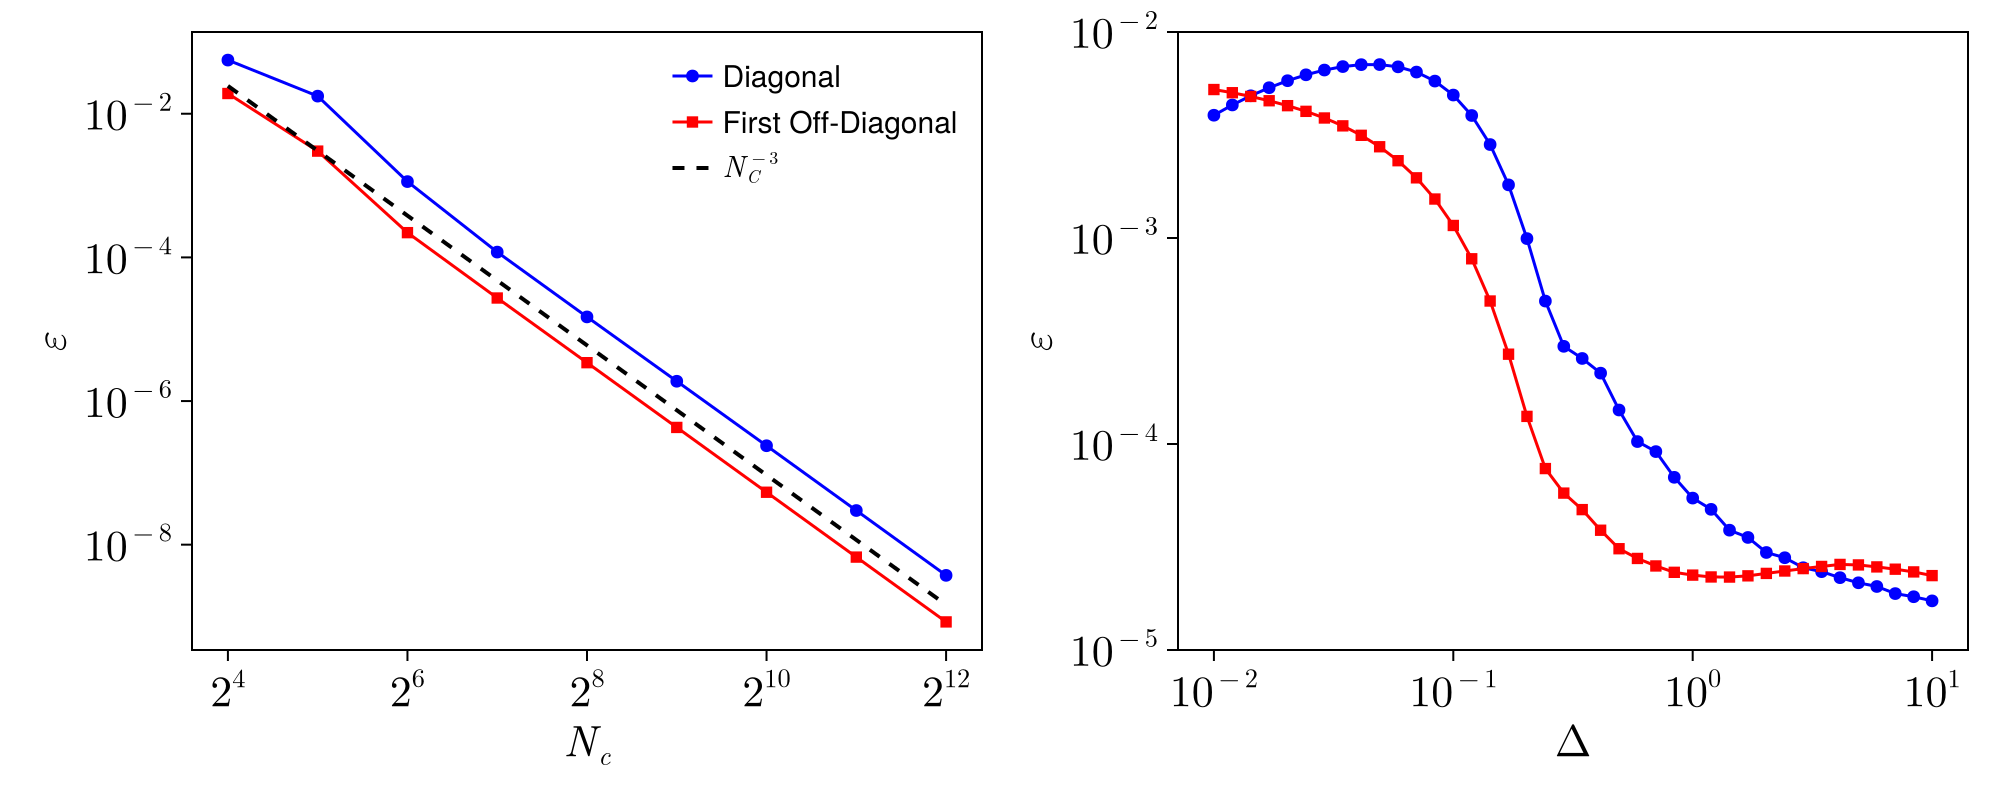

CairoMakie.Screen{PDF}


In [110]:
tick_positions = 2 .^ (4:2:12)        # 16, 64, 256, 1024
tick_labels = [L"2^4", L"2^6", L"2^8", L"2^{10}", L"2^{12}"]

ytick_positions = 10.0 .^ (-8:2:-2)        # 10^-6, 10^-4, 10^-2, 10^0
ytick_labels = [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}"]
fig = Figure(size = (1000, 400),fontsize=22)
ax = Axis(fig[1, 1],
     xlabel = L"N_c",
     ylabel = L"\varepsilon",
     xscale = log10,
     yscale = log10,
     xticks = (tick_positions, tick_labels),
     yticks = (ytick_positions, ytick_labels),
     titlefont = "times",
     xgridvisible = false,
     ygridvisible = false)

scatterlines!(ax, N_max_list, errorsDiagonal, color = :blue, marker = :circle, label = "Diagonal")
scatterlines!(ax, N_max_list, errorsOffiDiagonal, color = :red, marker = :rect, label = "First Off-Diagonal")
lines!(ax, N_max_list, 100 .*(N_max_list .^ -3), color = :black, linestyle = :dash, label = L"N_C^{-3}", linewidth = 2)

axislegend(ax,labelsize=15,framevisible=false)



ax = Axis(fig[1, 2],
     xlabel = L"\Delta",
     ylabel = L"\varepsilon",
     xscale = log10,
     
     yscale = log10,
     titlefont = "times",
     xgridvisible = false,
     ygridvisible = false)




ytick_positions = 10.0 .^ (-5:1:-2)        # 10^-6, 10^-4, 10^-2, 10^0
ytick_labels = [L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}"]

ax.yticks = (ytick_positions, ytick_labels)


xtick_positions = 10.0 .^ (-2:1:1)        # 10^-2, 10^-1, 10^0, 10^1         
xtick_labels = [L"10^{-2}", L"10^{-1}", L"10^{0}", L"10^{1}"]
ax.xticks = (xtick_positions, xtick_labels)

scatterlines!(ax, Δs, errors_gap_diagonal, color = :blue, marker = :circle, label = "Diagonal")
scatterlines!(ax, Δs, errors_gap_offdiagonal, color = :red, marker = :rect, label = "First Off-Diagonal")

ylims!(ax, 1e-5, 1e-2)
     

     
display(fig)



save("../../Figures/kpm_convergence_1d_chain_gapped_N=512.pdf", fig)

<!-- # Analyze the evaluation of the Heavyside function at the eigenvalues -->

16
32
64
128
256
512
1024
2048
4096


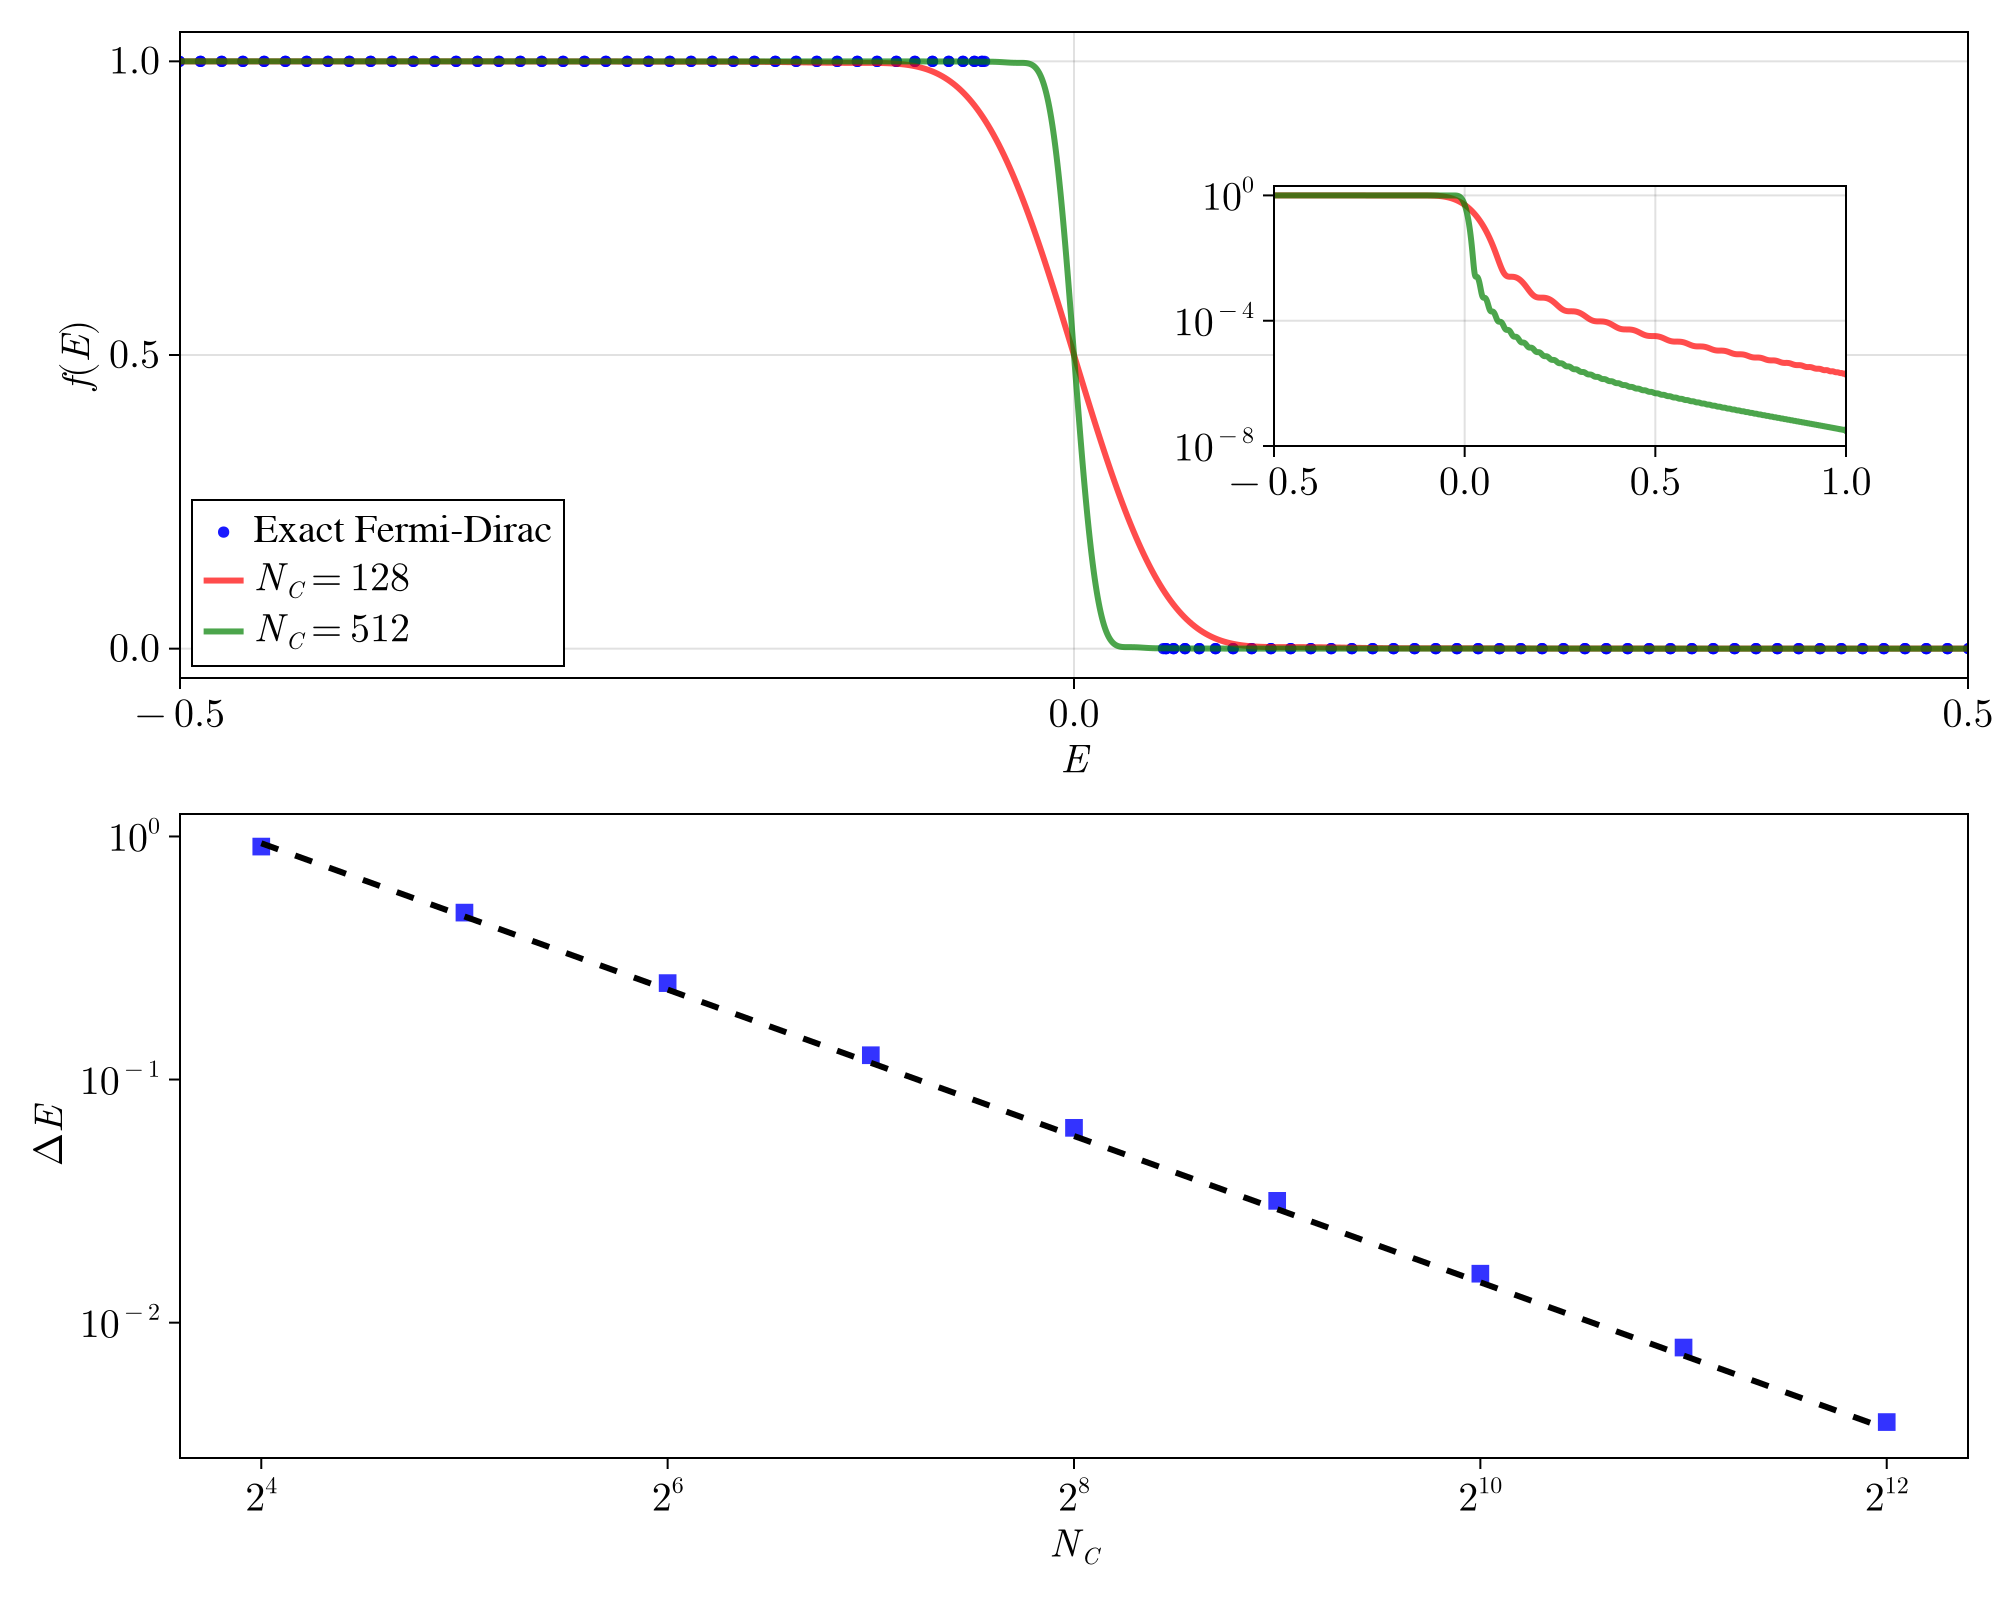

CairoMakie.Screen{IMAGE}


In [154]:
HamiltonianData = (N_sites = 1024, t = 1.0,Δ = 0.1, periodic=true, E_Fermi = 0.0)
HamiltonianData = one_dimensional_chain_gapped(HamiltonianData)

E, V = eigen(Matrix(HamiltonianData.H))
Fermi = map(x -> x < HamiltonianData.E_Fermi ? 1.0 : 0.0, E)



fig = Figure(size = (1000, 800),fontsize=20)
ax = Axis(fig[1, 1], xlabel=L"E",ylabel=L"f(E)")

xticks = [-0.5,0.0,0.5]
ax.xticks = (xticks, [L"%$x" for x in xticks])

yticks = [0.0,0.5,1.0]
ax.yticks = (yticks, [L"%$y" for y in yticks])



scatter!(ax, E, Fermi, marker=:circle, color=(:blue,0.9),markersize=8, label="Exact Fermi-Dirac")     
xlims!(ax, -0.5,0.5)




ax_inset = Axis(fig[1, 1],
    width=Relative(0.32),
    height=Relative(0.4),
    halign=0.9,
    valign=0.6)

N_max = 128

kpm_run_Params = (
     N_max = N_max,
     compute_density_matrix = true,
     compute_local_density_of_states = true,
     Energies = Float64[-0.1,0.0,0.1],
     kernel = :jackson)
rescaling_kpm = (a = 2.5, b = 0.0)

kernel = compute_jackson_kernel(kpm_run_Params)
Energies = LinRange(-0.5,1.0,1000)
f_energies_kpm = zeros(length(Energies))

for (i, E) in enumerate(Energies)

     cs = compute_FermiDirac_coefs(kpm_run_Params, E, rescaling_kpm)
     f_energies_kpm[i] = sum(kernel[n] * cs[n] * chebyshev_polynomial(n-1, E) for n in 1:N_max)
end


lines!(ax, Energies, f_energies_kpm, color=(:red,0.7),linewidth=3,label=L"N_C = %$N_max")

lines!(ax_inset, Energies, f_energies_kpm, color=(:red,0.7),linewidth=3,label=L"N_C = %$N_max")


N_max = 512

kpm_run_Params = (
     N_max = N_max,
     compute_density_matrix = true,
     compute_local_density_of_states = true,
     Energies = Float64[-0.1,0.0,0.1],
     kernel = :jackson)

rescaling_kpm = (a = 2.5, b = 0.0)

kernel = compute_jackson_kernel(kpm_run_Params)
Energies = LinRange(-0.5,1.0,4000)
f_energies_kpm = zeros(length(Energies))

for (i, E) in enumerate(Energies)

     cs = compute_FermiDirac_coefs(kpm_run_Params, E, rescaling_kpm)
     f_energies_kpm[i] = sum(kernel[n] * cs[n] * chebyshev_polynomial(n-1, E) for n in 1:N_max)
end


lines!(ax, Energies, f_energies_kpm, color=(:green,0.7),linewidth=3,label=L"N_C = %$N_max")


lines!(ax_inset, Energies, f_energies_kpm, color=(:green,0.7),linewidth=3,label=L"N_C = %$N_max")
ax_inset.yscale=log10
translate!(ax_inset.blockscene, 0, 0, 150)

xticks_inset = [-0.5,0.0,0.5,1.0]
ax_inset.xticks = (xticks_inset, [L"%$x" for x in xticks_inset])

yticks_inset = [1e-8,1e-4,1e0]
ax_inset.yticks = (yticks_inset, [L"10^{%$(Int64(round(log10(y),digits=0)))}" for y in yticks_inset])

xlims!(ax_inset,-0.5,1.0)
ylims!(ax_inset,1e-8,2)

axislegend(ax,labelfont="times",position=:lb)
# display(fig)

# N_Max_list = 2 .^ (6:11)  # 64 to 2048
N_Max_list = 2 .^ (4:12)
ΔE_list = zeros(length(N_Max_list))
Energies = LinRange(-0.5,0.5,10000)

# ensure rescaling is defined (adjust 'a' as needed)
rescaling_kpm = (a = 2.5, b = 0.0)

for (j,N_max) in enumerate(N_Max_list)
     kpm_run_Params = (
          N_max = N_max,
          compute_density_matrix = true,
          compute_local_density_of_states = true,
          Energies = Float64[-0.1,0.0,0.1],
          kernel = :jackson)
     println(N_max)
     kernel = compute_jackson_kernel(kpm_run_Params)        # <-- compute once per N_max
     f_energies_kpm = zeros(length(Energies))
     for (i, E) in enumerate(Energies)
          cs = compute_FermiDirac_coefs(kpm_run_Params, E, rescaling_kpm)
          f_energies_kpm[i] = sum(kernel[n] * cs[n] * chebyshev_polynomial(n-1, E) for n in 1:N_max)
     end

     f_max = 0.95
     f_min = 0.05

     E_max = Energies[argmin(abs.(f_energies_kpm .- f_max))]
     E_min = Energies[argmin(abs.(f_energies_kpm .- f_min))]
     ΔE_list[j] = E_max - E_min
end

# fig = Figure(size = (800, 500),fontsize=22)
ax = Axis(fig[2, 1],
     xlabel = L"N_C",
     ylabel = L"\Delta E",
     xscale = log10,
     yscale = log10,
     titlefont = "times",
     xgridvisible = false,
     ygridvisible = false)

scatter!(ax, N_Max_list, abs.(ΔE_list), color = (:blue,0.8), marker = :rect, markersize=14)

lines!(ax, N_Max_list, 15 .*(N_Max_list .^ -1), color = :black, linestyle = :dash, label = L"N_C^{-1}", linewidth = 3)



xticks = [16,64,256,1024,4096]
ax.xticks = (xticks, [L"2^{%$(Int64(round(log2(x),digits=0)))}" for x in xticks])

yticks = [1e-2,1e-1,1e0]
ax.yticks = (yticks, [L"10^{%$(Int64(round(log10(y),digits=0)))}" for y in yticks])

display(fig)


# save("../../Figures/FermiDirac_KPM.pdf", fig)

# Cálculo "Temperatura" Efetiva

In [242]:
# N_Max_list = 2 .^ (6:11)  # 64 to 2048
N_Max_list = 2 .^ (4:12)
ΔE_list = zeros(length(N_Max_list))
Energies = LinRange(-0.5,0.5,10000)

# ensure rescaling is defined (adjust 'a' as needed)
rescaling_kpm = (a = 2.5, b = 0.0)

for (j,N_max) in enumerate(N_Max_list)
     println(N_max)
     kernel = compute_jackson_kernel(N_max)        # <-- compute once per N_max
     f_energies_kpm = zeros(length(Energies))
     for (i, E) in enumerate(Energies)
          cs = compute_FermiDirac_coefs(N_max, E, rescaling_kpm)
          f_energies_kpm[i] = sum(kernel[n] * cs[n] * chebyshev_polynomial(n-1, E) for n in 1:N_max)
     end

     f_max = 0.95
     f_min = 0.05

     E_max = Energies[argmin(abs.(f_energies_kpm .- f_max))]
     E_min = Energies[argmin(abs.(f_energies_kpm .- f_min))]
     ΔE_list[j] = E_max - E_min
end


16
32
64
128
256
512
1024
2048
4096


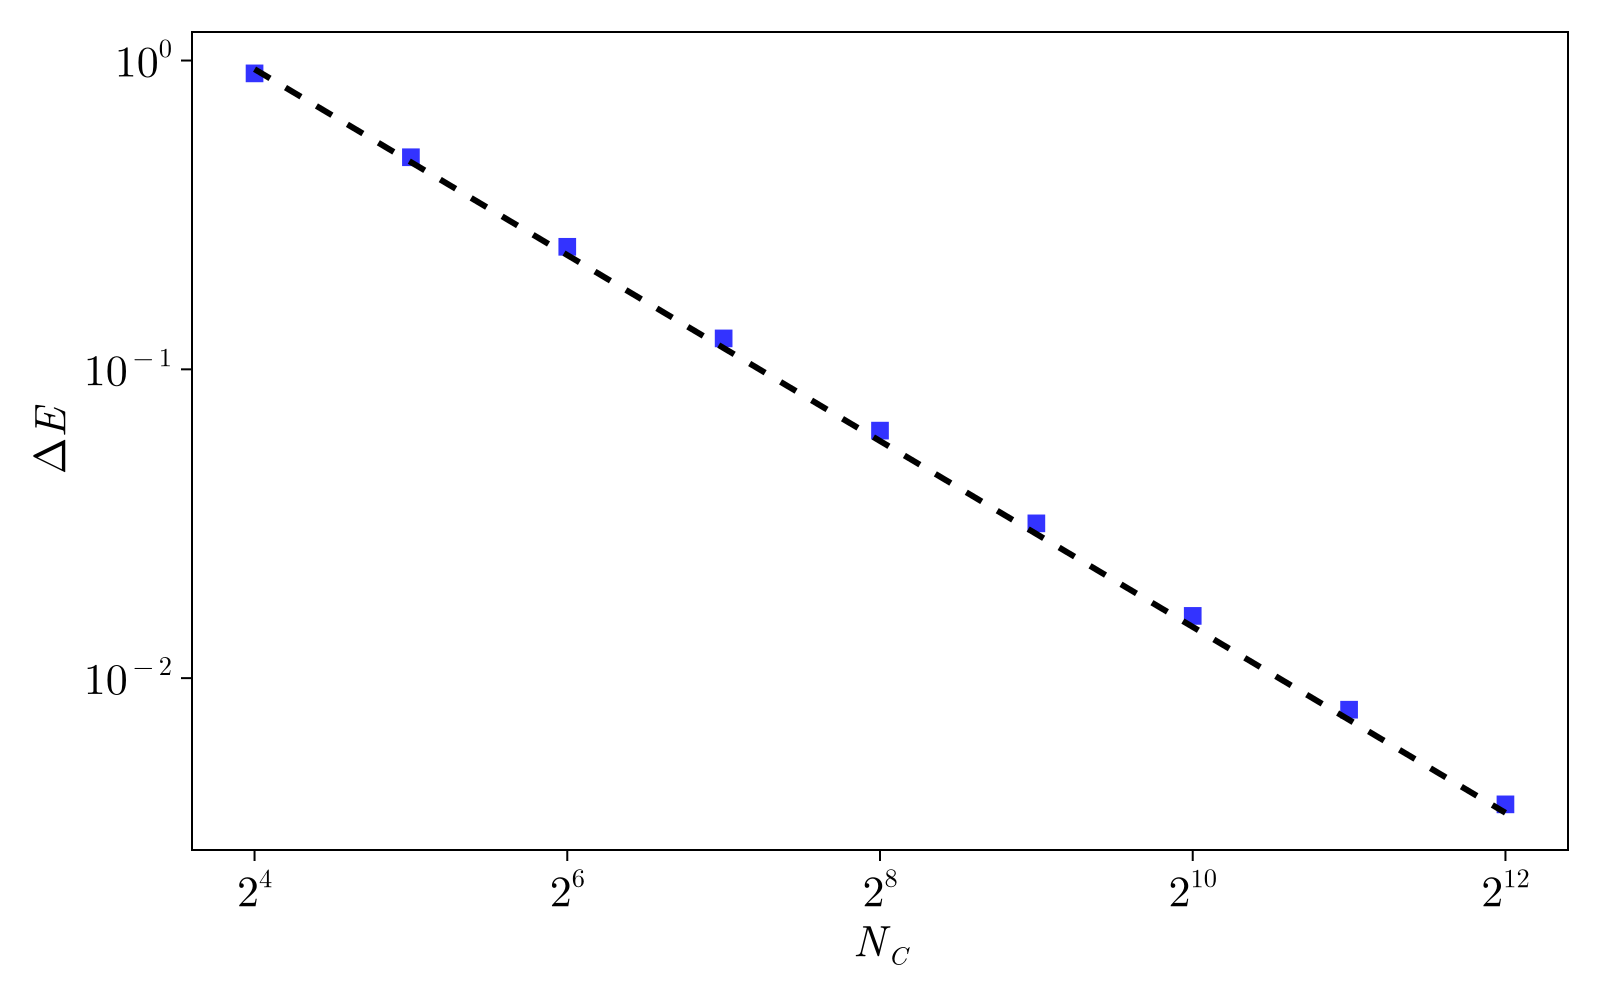

CairoMakie.Screen{IMAGE}


In [248]:
fig = Figure(size = (800, 500),fontsize=22)
ax = Axis(fig[1, 1],
     xlabel = L"N_C",
     ylabel = L"\Delta E",
     xscale = log10,
     yscale = log10,
     titlefont = "times",
     xgridvisible = false,
     ygridvisible = false)

scatter!(ax, N_Max_list, abs.(ΔE_list), color = (:blue,0.8), marker = :rect, markersize=14)

lines!(ax, N_Max_list, 15 .*(N_Max_list .^ -1), color = :black, linestyle = :dash, label = L"N_C^{-1}", linewidth = 3)



xticks = [16,64,256,1024,4096]
ax.xticks = (xticks, [L"2^{%$(Int64(round(log2(x),digits=0)))}" for x in xticks])

yticks = [1e-2,1e-1,1e0]
ax.yticks = (yticks, [L"10^{%$(Int64(round(log10(y),digits=0)))}" for y in yticks])

display(fig)

# Analyzing convergence of the LDOS!

## Obtain charge density as function of the chemical potential

In [117]:
HamiltonianData = (N_sites = 2048, t = 1.0,Δ = 0.5, periodic=false, E_Fermi = 0.0)
HamiltonianData = one_dimensional_chain_gapped(HamiltonianData)


Es = LinRange(-0.5,0.5,10000)
rescaling_kpm = (a = 2.5, b = 0.0)
kpm_run_Params  = (
     N_max = 512,
     compute_density_matrix = true,
     compute_spectral_function = false,
     compute_ldos = false,
     Energies = Es)



kpm_result = run_kpm_evolution(HamiltonianData, rescaling_kpm, kpm_run_Params)


(moments = [2048.0, 0.0, -696.9599999999909, 0.0, -735.1807999999835, -1.4210854715202004e-14, 56.52480000000064, -2.842170943040401e-14, 375.4778624000065, 2.842170943040401e-14  …  0.0, 67.01122163106814, 0.0, 38.187893866772335, -3.552713678800501e-15, -18.1732101408553, 1.7763568394002505e-14, -60.44499685109032, 3.552713678800501e-15, -21.147005359117944], density_matrix = [0.30270993828859827 0.4046626186532899 … 0.0 0.0; 0.40466261865329 0.6011656546633226 … 0.0 0.0; … ; 0.0 0.0 … 0.3988343453366772 0.40466261865329; 0.0 0.0 … 0.40466261865328995 0.6972900617114001], spectral_function = nothing, LDOS = nothing)

In [118]:
densities = zeros(length(Es))
dos = zeros(length(Es))
coefs_spectral = compute_spectral_coefs(kpm_run_Params, rescaling_kpm)
for i in eachindex(Es)

     coefs = compute_FermiDirac_coefs(kpm_run_Params, Es[i], rescaling_kpm)

     
     

     moments = kpm_result.moments
     kernel_coefs = compute_jackson_kernel(kpm_run_Params)


     densities[i] = compute_charge_density(coefs, moments, kernel_coefs, HamiltonianData)
     dos[i] = sum(coefs_spectral[:,i] .* moments .* kernel_coefs)
end



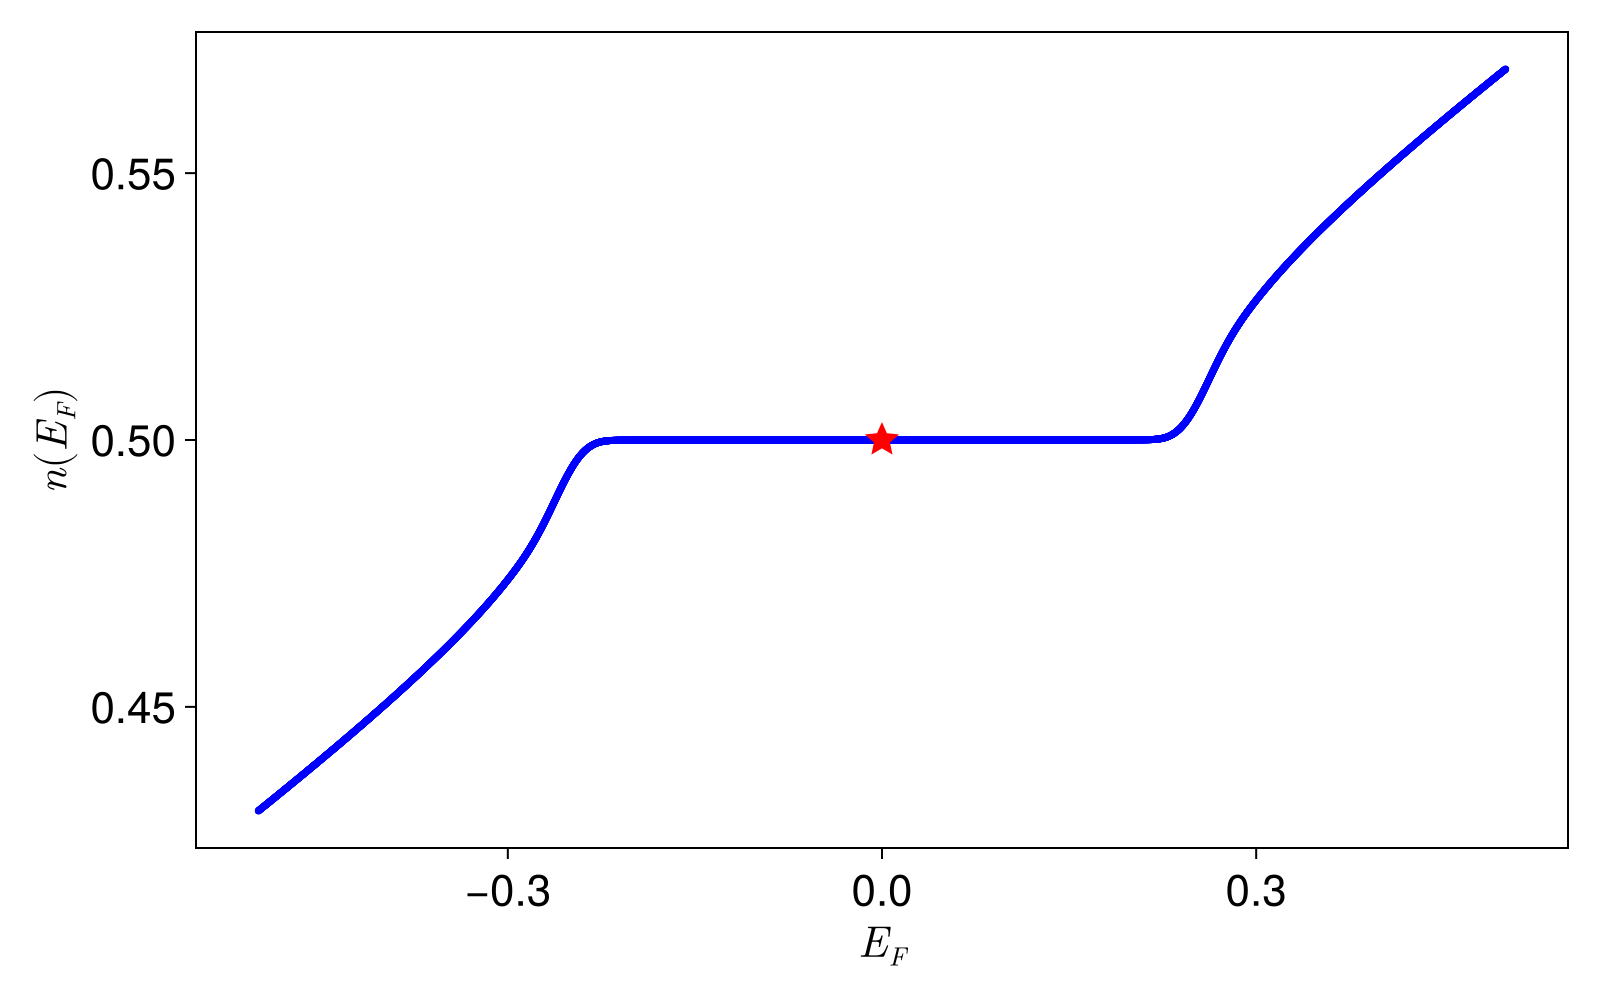

CairoMakie.Screen{IMAGE}


In [142]:
fig = Figure(size = (800, 500),fontsize=22)
ax = Axis(fig[1, 1],
     xlabel = L"E_F",
     ylabel = L"n(E_F)",
     titlefont = "times",
     xgridvisible = false,
     ygridvisible = false)




scatterlines!(ax, Es, densities , color = (:blue,0.9) , marker = :circle, markersize=5)

min_ind= argmin(abs.(densities .-0.5))

scatter!(ax, Es[min_ind],densities[min_ind], color = :red, marker = :star5, markersize=20,label=L"n(E_F=%$(round(mean(Es[inds]),digits=4)))=%$(round(mean(densities[inds]),digits=4))")

# axislegend(ax,labelfont="times",position=:lt)
display(fig)

# Mean Field Loop!

In [101]:
# --- 1. Hamiltonian Parameters ---
N_sites = 1024
t = 1.0
E_Fermi = 0.0


HamiltonianData = (N_sites = N_sites, t = t, periodic=true, E_Fermi = E_Fermi)

# --- 2. Interaction Parameters ---

U = 2.0
InteractionData = (U = U,
                   type_of_guess=:CDW,
                   density_target = 0.6)

# --- 3. KPM Parameters ---

N_max = 256
compute_density_matrix = true
compute_ldos = false
Energies = Float64[]
compute_spectral_function = false 
E_min = -5.0
E_max = 5.0
scaling_a = (E_max - E_min) / 2 * 1.1
scaling_b = (E_max + E_min) / 2


kpm_params = (
     N_max = N_max,
     compute_density_matrix = compute_density_matrix,
     compute_ldos = compute_ldos,
     compute_spectral_function = compute_spectral_function,
     Energies = Energies,
     kernel = :jackson,
     scaling_a = scaling_a,
     scaling_b = scaling_b)

# --- 4. SCF Parameters ---

scf_params = (
     max_iterations = 100,
     convergence_tol = 1e-5,
     mixing_parameter = 0.952)







# mf_result = run_scf_loop()

(max_iterations = 100, convergence_tol = 1.0e-5, mixing_parameter = 0.952)

In [102]:


# --- 5. Define the functions to be used ---
hamiltonian_builder = one_dimensional_chain # Or one_dimensional_AubryAndre, etc.
meanfield_starter = StartMeanField_1stNeighbor_Repulsion
meanfield_updater = MeanField_1stNeighbor_Repulsion

# --- 6. Execute the SCF loop ---
(final_kpm_result, scf_history) = run_scf_loop(
    HamiltonianData,
    InteractionData,
    kpm_params,
    scf_params,

    hamiltonian_builder,
    meanfield_starter,
    meanfield_updater
)

println("--- Run Finished ---")

--- Starting SCF loop ---
Hamiltonian constructed from: one_dimensional_chain
Mean-field starter: StartMeanField_1stNeighbor_Repulsion
Mean-field updater: MeanField_1stNeighbor_Repulsion
SCF Iteration: 1
SCF Error: 1.7384427481202662
SCF Iteration: 2
SCF Error: 0.14290433434454775


LoadError: Failed to converge to target charge density 0.6 within 400 iterations

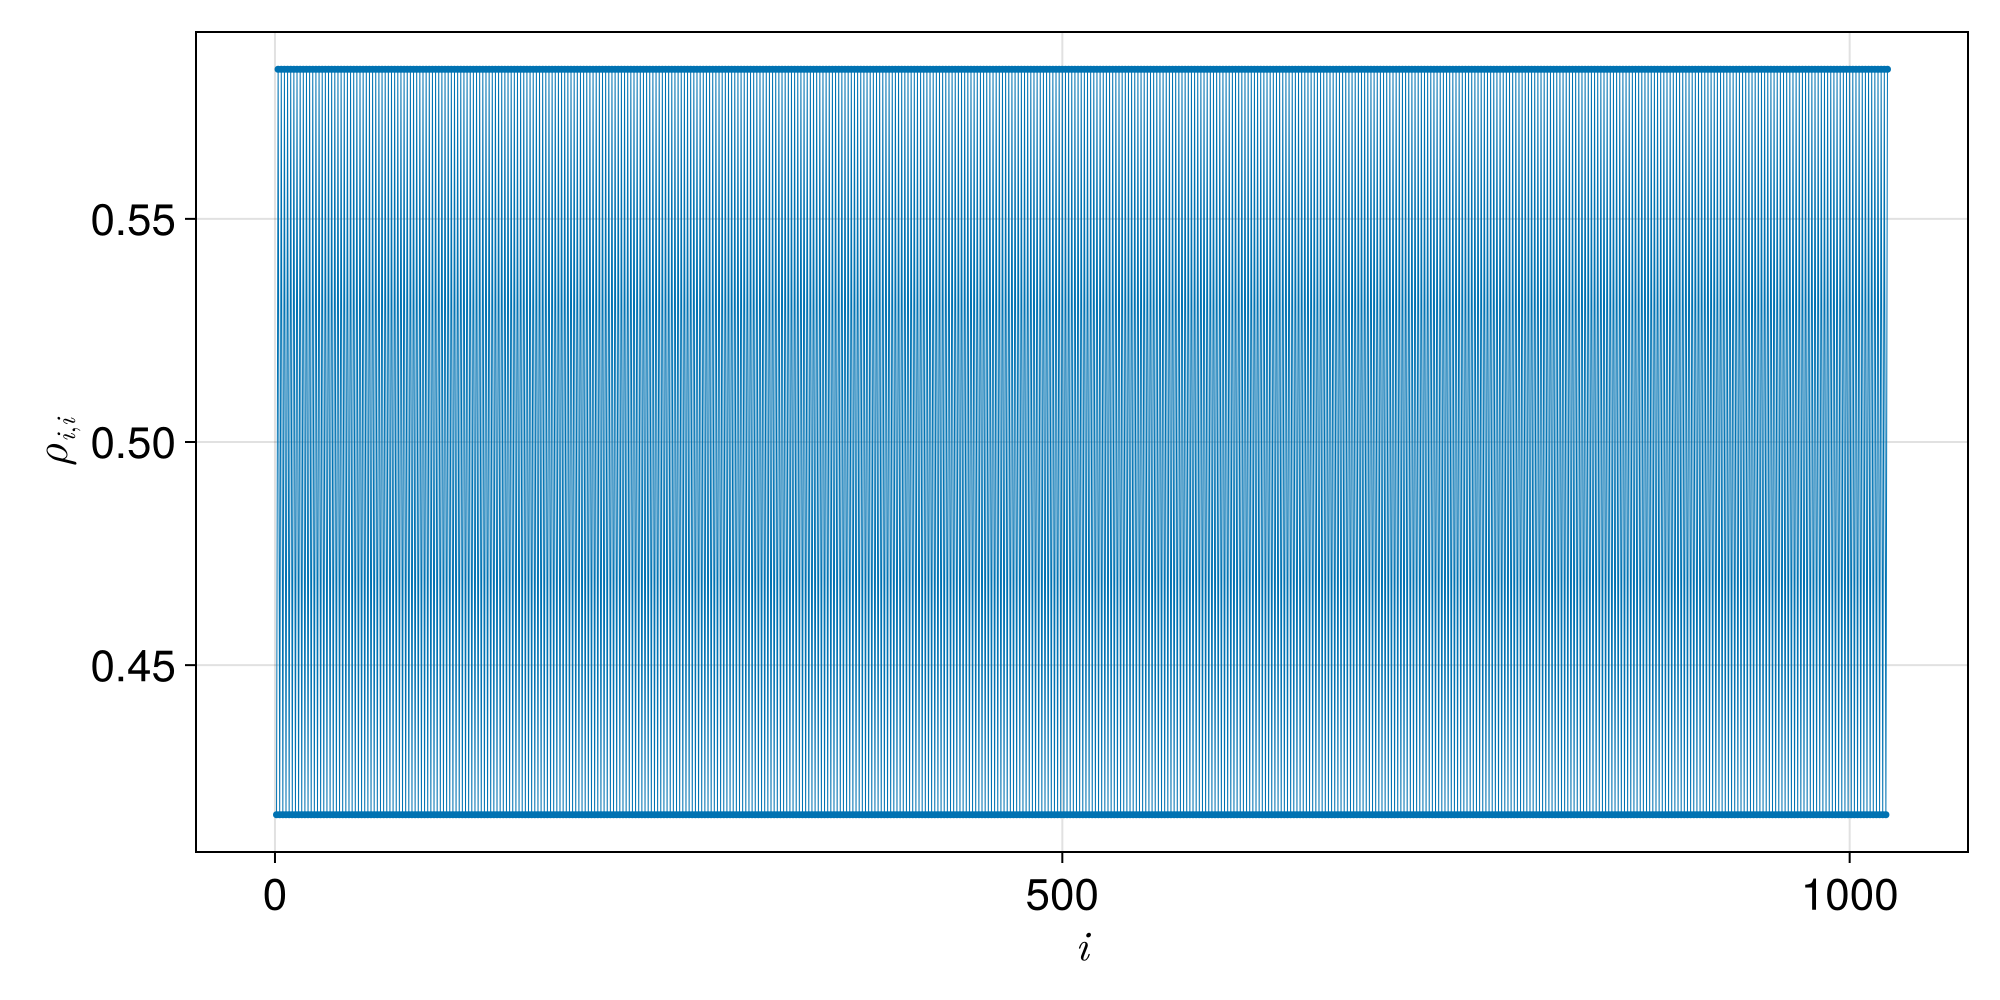

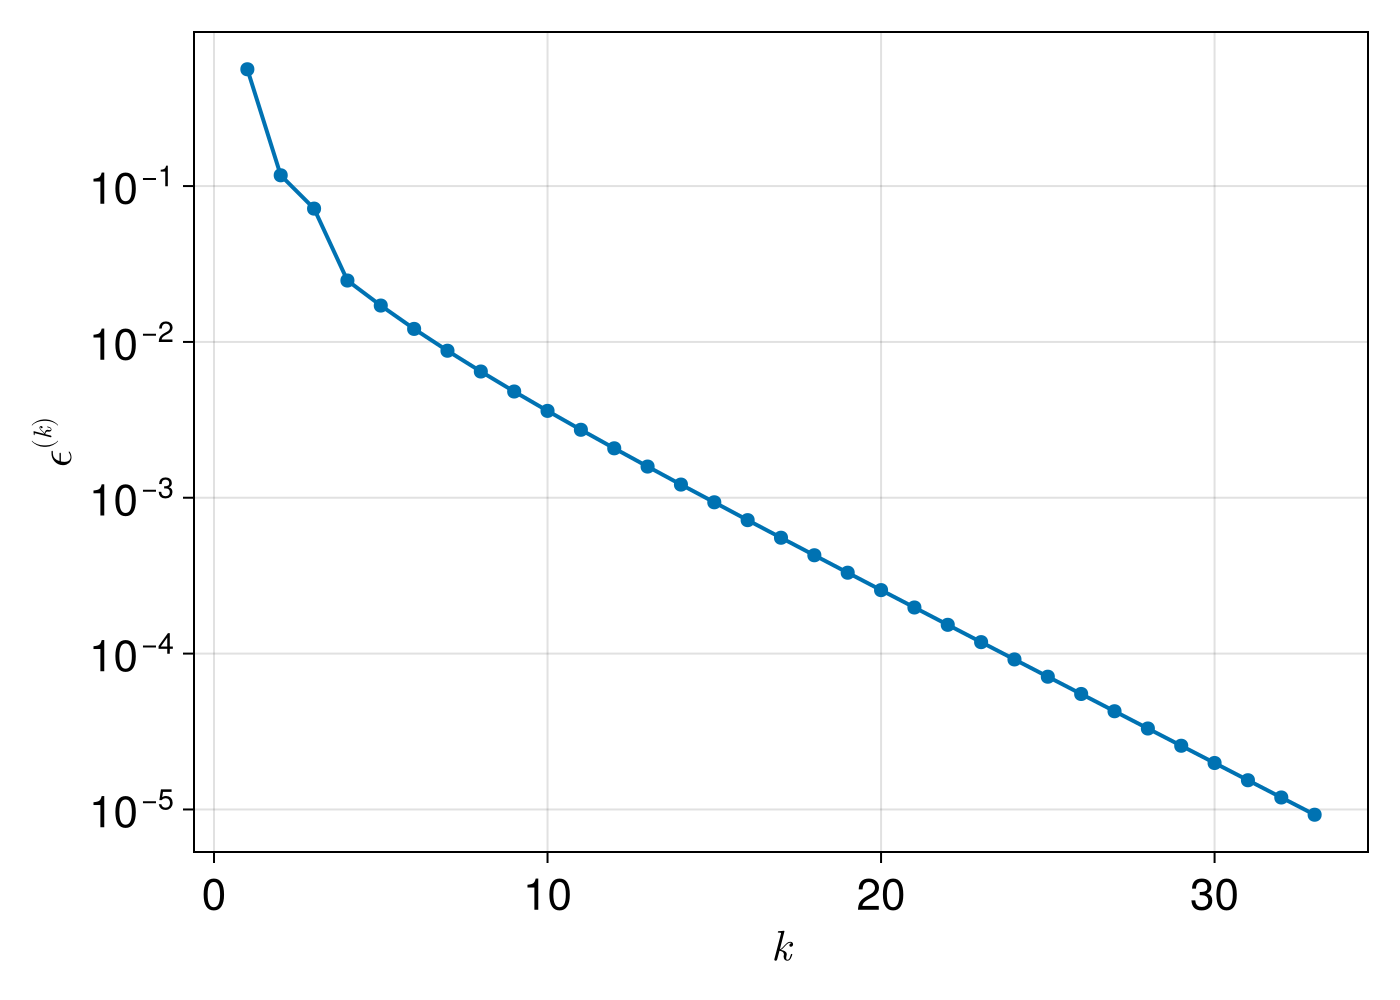

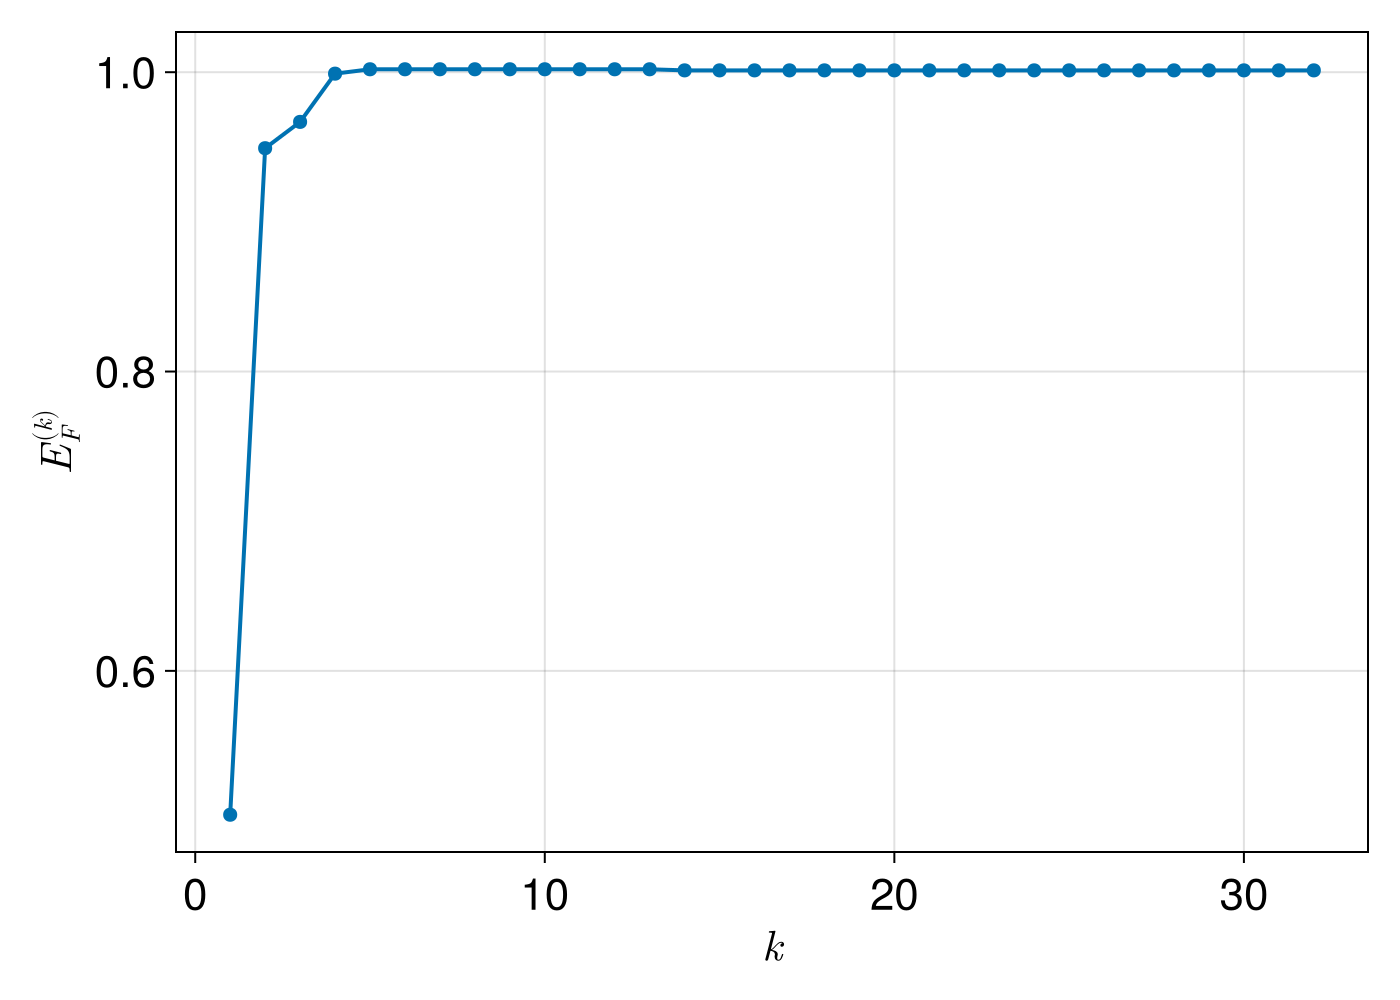

CairoMakie.Screen{IMAGE}


In [100]:

fig = Figure(size = (1000, 500),fontsize=22)
ax = Axis(fig[1, 1], xlabel=L"i",ylabel=L"\rho_{i,i}")

scatterlines!(ax,diag(final_kpm_result.density_matrix) |> real,markersize=5,linewidth=0.5)
display(fig)



fig = Figure(size = (700, 500),fontsize=22)
ax = Axis(fig[1, 1], xlabel=L"k",ylabel=L"\epsilon^{(k)}",yscale=log10)

scatterlines!(ax,scf_history.errors, markersize=10,linewidth=2)

display(fig)



fig = Figure(size = (700, 500),fontsize=22)
ax = Axis(fig[1, 1], xlabel=L"k",ylabel=L"E_F^{(k)}")

scatterlines!(ax,scf_history.E_Fermi_values, markersize=10,linewidth=2)

display(fig)


